In [32]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
import statsmodels.tsa.stattools as stat 
import statsmodels.api as sm

In [33]:
def adf(ts):
	dftest = stat.adfuller(ts)
	dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
	if dftest[1] > 0.5:
		print("Process is non-stationary")
	else:
		print("Process is stationary")

rcParams['figure.figsize'] = 15, 6 #CHECK

In [3]:
#READING DATA

data = pd.read_csv('GAZP.csv', index_col="Date")
data = data.drop(["Open", "High", "Low", "Vol.", "Change %"], axis = 1)
data = data.iloc[::-1]

print(data.head())
print(data.dtypes)

               Price
Date                
Feb 10, 2021  223.24
Feb 11, 2021  221.35
Feb 12, 2021  226.71
Feb 15, 2021  229.22
Feb 16, 2021  232.46
Price    float64
dtype: object


In [4]:
#ADF TEST
ts = data["Price"]
adf(ts)

Process is non-stationary


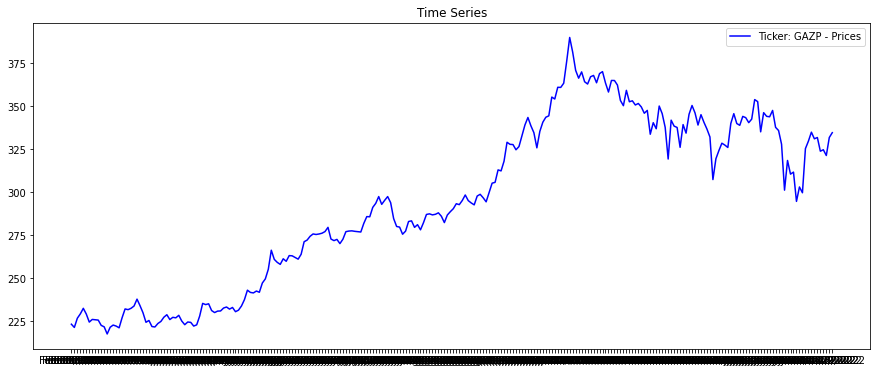

In [5]:
#VISUALIZATION
fig = plt.figure()
orig = plt.plot(ts, color = 'blue',label='Ticker: GAZP - Prices')
plt.legend(loc = 'best')
plt.title('Time Series')
plt.show(block=True)

<AxesSubplot:ylabel='Density'>

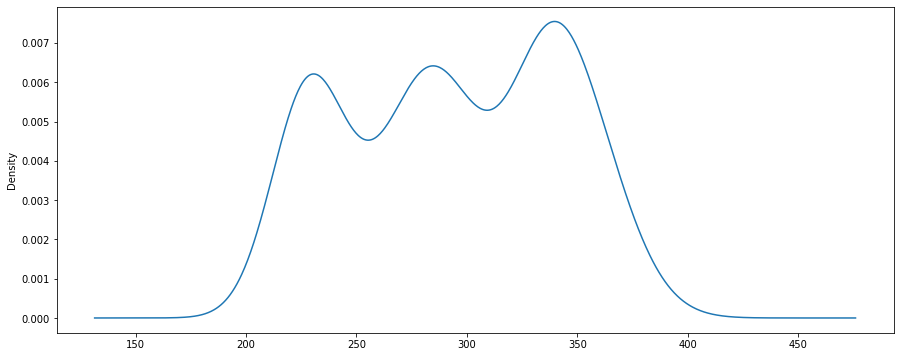

In [6]:
#That is how distribution space has been changing
data['Price'].plot(kind = "kde")

In [7]:
data.index = pd.to_datetime(data.index, infer_datetime_format=True)
data.head(10)

,Price
Date,
2021-02-10,223.24
2021-02-11,221.35
2021-02-12,226.71
2021-02-15,229.22
2021-02-16,232.46
2021-02-17,229.14
2021-02-18,224.47
2021-02-19,226.00
2021-02-20,225.84


In [ ]:
plt.plot(data)

In [16]:
#Moving Average Smoothing
rm = data.rolling(window = 10).mean()

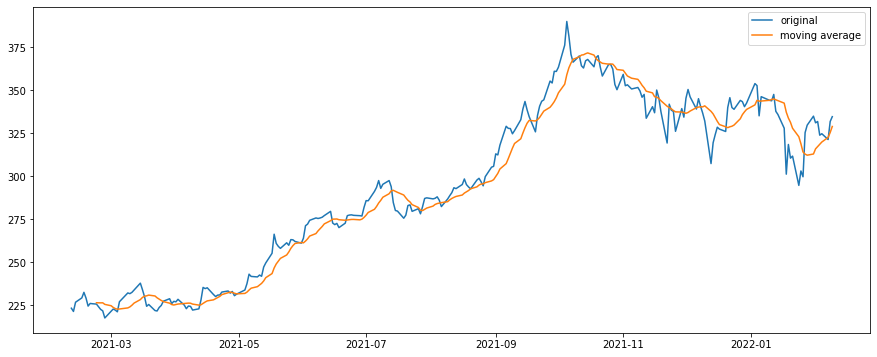

In [19]:
orig = plt.plot(data, label = 'original')
rmean = plt.plot(rm, label = 'moving average')
plt.legend(loc='best')
plt.show(block=True)

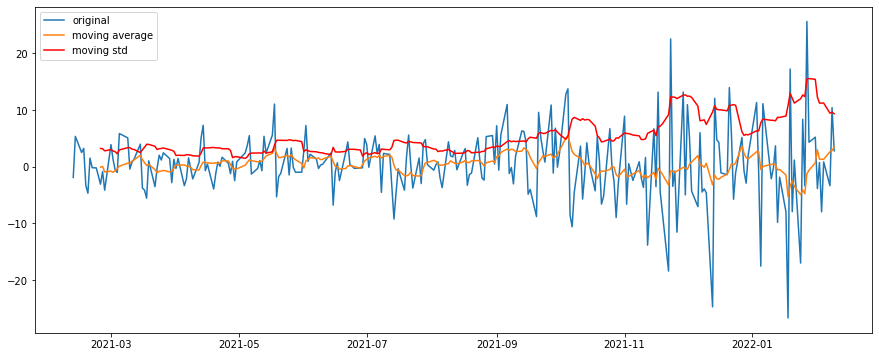

In [31]:
df_data = data - data.shift()
df_data
rm = df_data.rolling(window = 10).mean()
rstd = df_data.rolling(window = 10).std()
orig = plt.plot(df_data, label = 'original')
rmean = plt.plot(rm, label = 'moving average')
rs = plt.plot(rstd, color = 'red', label = 'moving std')
plt.legend(loc='best')
plt.show(block=True)

In [30]:
adf(df_data['Price'].dropna(axis = 0))

Process is stationary


<BarContainer object of 25 artists>

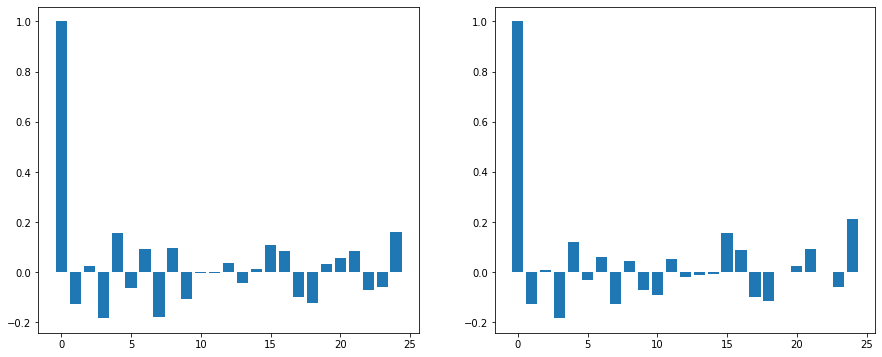

In [55]:
l_acf = stat.acf(df_data.dropna(axis = 0))
l_pacf = stat.pacf(df_data.dropna(axis = 0))

plt.figure()
plt.subplot(121)
plt.bar([i for i in range(25)], l_acf)
plt.subplot(122)
plt.bar([i for i in range(25)], l_pacf)

C:\Users\timos\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\timos\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\timos\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


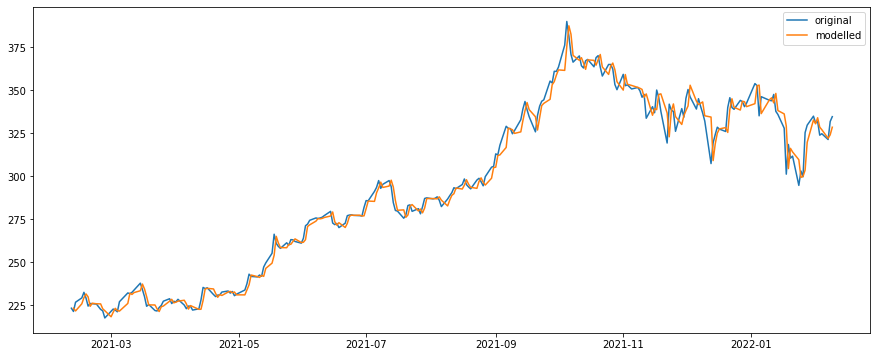

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  256
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -815.153
Date:                Wed, 23 Feb 2022   AIC                           1640.306
Time:                        17:37:42   BIC                           1658.012
Sample:                             0   HQIC                          1647.428
                                - 256                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2209      0.441     -0.500      0.617      -1.086       0.644
ar.L2          0.6569      0.387      1.698      0.089      -0.101       1.415
ma.L1          0.0975      0.426      0.229      0.8

In [70]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(data, order = (2,1,2))
res = model.fit()
orig = plt.plot(data, label = 'original')
arma = plt.plot(res.fittedvalues.drop([res.fittedvalues.index[0]], axis = 0), label = 'modelled')
plt.legend(loc='best')
plt.show(block=True)

print(res.summary())

In [75]:
#here we could use auto ARIMA
import warnings
import itertools
warnings.filterwarnings("ignore")

#find the best p and q considering Akaike Criterion
p = range(0,10)
q = range(0,3)
pdq = list(itertools.product(p, range(1, 2), q))
best_pdq = (2, 1, 2)
best_aic = np.inf
for params in pdq:
  model_test = ARIMA(data, order = params)
  result_test = model_test.fit()
  if np.abs(result_test.aic) < best_aic:
    best_pdq = params
    best_aic = result_test.aic
print(best_pdq, best_aic)

(3, 1, 1) 1635.9090253691506


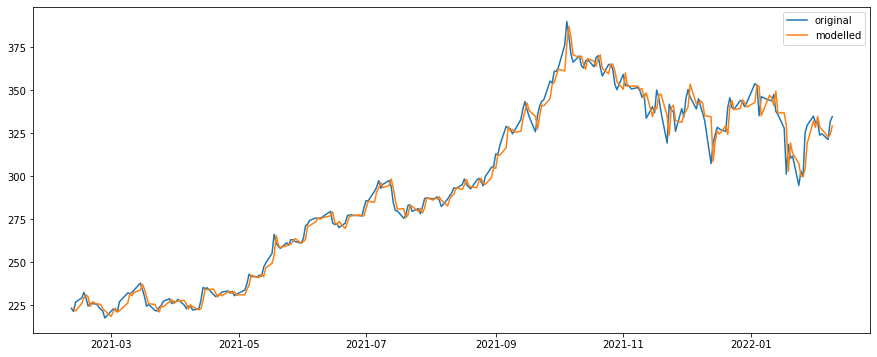

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  256
Model:                 ARIMA(3, 1, 1)   Log Likelihood                -812.955
Date:                Wed, 23 Feb 2022   AIC                           1635.909
Time:                        17:51:30   BIC                           1653.615
Sample:                             0   HQIC                          1643.031
                                - 256                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7698      0.127     -6.061      0.000      -1.019      -0.521
ar.L2         -0.0810      0.063     -1.282      0.200      -0.205       0.043
ar.L3         -0.1629      0.061     -2.673      0.0

In [76]:
model = ARIMA(data, order = best_pdq)
res = model.fit()
orig = plt.plot(data, label = 'original')
arma = plt.plot(res.fittedvalues.drop([res.fittedvalues.index[0]], axis = 0), label = 'modelled')
plt.legend(loc='best')
plt.show(block=True)

print(res.summary())

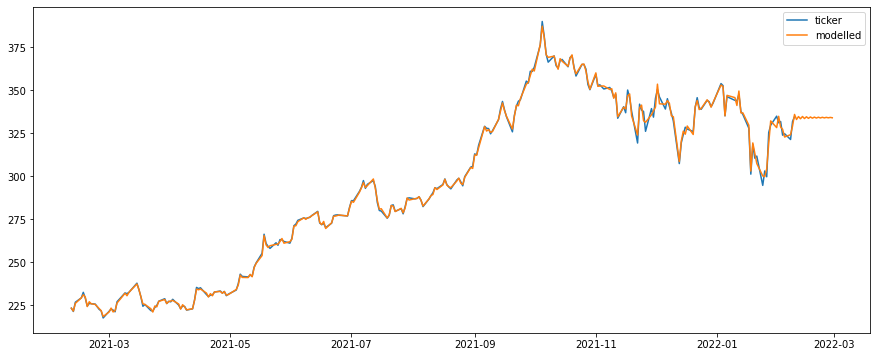

In [140]:
#make prediction
pred = res.get_prediction(start=1, end=275, dynamic=False)
conf = pred.conf_int()
pred = pd.DataFrame({'Price': list(pred.predicted_mean), 'Date': list(data.index) + list(pd.date_range('2022-02-10','2022-02-28'))})
pred.index = pred.Date
pred.pop('Date')

ts = plt.plot(data, label = 'ticker')
pr = plt.plot(pred, label = 'modelled')
plt.legend(loc='best')
plt.show(block=True)

In [141]:
pred.tail(20)


,Price
Date,
2022-02-09,335.801933
2022-02-10,332.877346
2022-02-11,334.566318
2022-02-12,333.292605
2022-02-13,334.612723
2022-02-14,333.424524
2022-02-15,334.439761
2022-02-16,333.539426
2022-02-17,334.343830


In [164]:
#CROSS VALIDATION ON A ROLLING BASIS CANDIDATES: ARIMA(3,1,1), ARIMA(2,1,2)
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error as MSE
from math import sqrt
av_rmse = []
for i in list(itertools.product(p, range(1, 2), q)):
    tscv = TimeSeriesSplit(n_splits = 5)
    rmse = []
    for train_index, test_index in tscv.split(data):
        cv_train, cv_test = data.iloc[train_index], data.iloc[test_index]

        mod = ARIMA(cv_train, order = i).fit()
        predictions = mod.predict(1, len(cv_test))
        true_values = cv_test.Price
        rmse.append(sqrt(MSE(true_values, predictions)))
    print(*i, "RMSE: {}".format(np.mean(rmse)))
    av_rmse.append(np.mean(rmse))
#CV has not revealed meaningful difference between two models (MRMSEs are almast equal)

0 1 0 RMSE: 85.18940756260322
0 1 1 RMSE: 85.20973335776156
0 1 2 RMSE: 85.21128206656388
1 1 0 RMSE: 85.21024838141693
1 1 1 RMSE: 85.210862533113
1 1 2 RMSE: 85.22279634214593
2 1 0 RMSE: 85.20693461572726
2 1 1 RMSE: 85.21190100696506
2 1 2 RMSE: 85.21818075948804
3 1 0 RMSE: 85.20299752568567
3 1 1 RMSE: 85.20769811360317
3 1 2 RMSE: 85.22565052568208
4 1 0 RMSE: 85.21576768274107
4 1 1 RMSE: 85.20655104177388
4 1 2 RMSE: 85.20202525668253
5 1 0 RMSE: 85.21836762528991
5 1 1 RMSE: 85.24543573812434
5 1 2 RMSE: 85.21169569498105
6 1 0 RMSE: 85.22036961364346
6 1 1 RMSE: 85.23288711233116
6 1 2 RMSE: 85.24722398818915
7 1 0 RMSE: 85.2191094812751
7 1 1 RMSE: 85.24512122664154
7 1 2 RMSE: 85.22890749228027
8 1 0 RMSE: 85.2175430265579
8 1 1 RMSE: 85.24573942472641
8 1 2 RMSE: 85.2385135042698
9 1 0 RMSE: 85.21725257622941
9 1 1 RMSE: 85.24387693751353
9 1 2 RMSE: 85.26177078344622


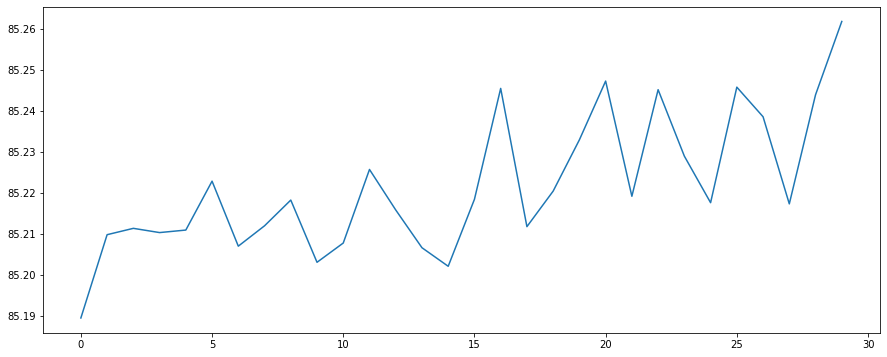

In [165]:
plt.plot(av_rmse)